# Stock Trading Using Deep Reinforcement Algorithm

## Cleaning and Combining the data

In [6]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

### Clean Data

In [4]:
# Read the data
df_basic = pd.read_csv('MSFT_Stock_with_indicators.csv')
df_fundamental = pd.read_csv('fundamentals.csv')
df_news_sentiment = pd.read_csv('news_sentiment_MSFT.csv')
df_reddit_sentiment = pd.read_csv('Reddit_sentiment_MSFT.csv')

# Convert the 'Date' column to datetime format
df_basic['Date'] = pd.to_datetime(df_basic['Date'])
df_fundamental['Report Date'] = pd.to_datetime(df_fundamental['Report Date'])
df_news_sentiment['Date'] = pd.to_datetime(df_news_sentiment['Date'])
df_reddit_sentiment['Date'] = pd.to_datetime(df_reddit_sentiment['Date'])

# set date as index
df_basic.set_index('Date', inplace=True)
df_fundamental.set_index('Report Date', inplace=True)
df_news_sentiment.set_index('Date', inplace=True)
df_reddit_sentiment.set_index('Date', inplace=True)

# Create a complete date range from the minimum to the maximum date in the DataFrame
start_date = '2014-01-01'
end_date = '2023-12-31'
date_range = pd.date_range(start=start_date, end=end_date)

# Reindex the DataFrame using the complete date range, forward-filling the missing values
df_news_sentiment = df_news_sentiment.reindex(date_range)
df_reddit_sentiment = df_reddit_sentiment.reindex(date_range)

# Shift the 'Sentiment' column upwards by one
df_news_sentiment['Sentiment'] = df_news_sentiment['Sentiment'].shift(1)
df_reddit_sentiment['Sentiment'] = df_reddit_sentiment['Sentiment'].shift(1)

# Fill the first value as it is null and cant be filled with forward fill
df_news_sentiment.iloc[0] = df_news_sentiment.iloc[1]
df_reddit_sentiment.iloc[0] = df_reddit_sentiment.iloc[1]

df_news_sentiment["Sentiment"] = df_news_sentiment["Sentiment"].fillna(method='ffill')
df_reddit_sentiment["Sentiment"] = df_reddit_sentiment["Sentiment"].fillna(method='ffill')

### Combine Data

In [5]:
# Merge the three dataframes based on the nearest timestamp
merged_data = pd.merge_asof(df_basic, df_fundamental, left_index=True, right_index=True, direction='nearest')
merged_data = pd.merge_asof(merged_data, df_news_sentiment, left_index=True, right_index=True)
merged_data = merged_data.rename(columns={'Sentiment': 'News Sentiment'})
merged_data = pd.merge_asof(merged_data, df_reddit_sentiment, left_index=True, right_index=True)
merged_data = merged_data.rename(columns={'Sentiment': 'Reddit Sentiment'})


merged_data = merged_data.drop(columns=[ 'Unnamed: 0'], axis=1)
merged_data.reset_index(inplace=True)
merged_data.to_csv('input_data.csv', index=False)

merged_data[400:500]

,Date,Symbol,Open,High,Low,Close,Volume,CDL_DOJI_10_0.1,CDL_INSIDE,open_Z_30_1,high_Z_30_1,low_Z_30_1,close_Z_30_1,HA_open,HA_high,HA_low,HA_close,SMA_20,SMA_50,SMA_100,EMA_20,EMA_50,EMA_100,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,BBP_5_2.0,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,ROC_10,SQZ_20_2.0_20_1.5,SQZ_ON,SQZ_OFF,SQZ_NO,STOCHk_14_3_3,STOCHd_14_3_3,FWMA_10,LR_14,PCTRET_1,LOGRET_1,ENTP_10,STDEV_30,ADX_14,DMP_14,DMN_14,AROOND_14,AROONU_14,AROONOSC_14,ZS_30,ATRr_14,RVI_14,Revenue,Shares,Cost of Revenue,Operating Expenses,Operating Income,Pretax Income,Net Income,Total Current Assets,"Property, Plant & Equipment, Net",Total Noncurrent Assets,Total Assets,Payables & Accruals,Total Current Liabilities,Total Noncurrent Liabilities,Total Liabilities,Retained Earnings,Total Equity,Total Liabilities & Equity,Non-Cash Items,Change in Working Capital,Net Cash from Operating Activities,Change in Fixed Assets & Intangibles,Net Cash from Investing Activities,Net Cash from Financing Activities,Net Change in Cash,EBITDA,Total Debt,Operating Margin,Net Profit Margin,ROE,Return on Assets,Current Ratio,Liabilities to Equity Ratio,Debt Ratio,Earnings Per Share,Sales Per Share,Equity Per Share,Return On Invested Capital,Free Cash Flow,Net Debt / EBITDA,Net Debt / EBIT,Shares Outstanding,Market-Cap,P/E Ratio,P/S Ratio,P/B Ratio,Enterprise Value,EV/EBITDA,EV/Sales,Book to Market Value,Operating Income/EV,News Sentiment,Reddit Sentiment
400,2014-02-14 14:30:00,MSFT,37.65,37.78,37.65,37.78,1433676,0.0,0,0.272296,1.040493,0.685221,1.478051,37.643560,37.780000,37.643560,37.7150,37.6495,37.4912,36.8846,37.625705,37.424815,37.141099,37.548401,37.668,37.787599,0.635018,0.968230,63.159595,0.054689,-0.006206,0.060895,0.881175,-0.040000,0,1,0,82.945736,74.935401,37.693497,37.662396,0.003453,0.003447,3.322665,0.097651,28.251916,24.341687,15.597310,28.571429,100.000000,71.428571,1.478051,0.112928,55.060619,8.334700e+10,8.324000e+09,-2.518300e+10,-3.081400e+10,27350000000,27388000000,22427000000,1.090060e+11,1.177100e+10,4.711300e+10,156119000000,8.470000e+09,3.390300e+10,3.479200e+10,6.869500e+10,1.962100e+10,8.742400e+10,156119000000,4.505600e+10,-4.331600e+10,28620000000,-5.949000e+09,-1.576200e+10,-6.554000e+09,6332000000,3.180300e+10,22679000000,0.32815,0.26908,0.25653,0.14365,3.21523,0.78577,0.14527,2.69426,10.01285,10.50264,0.24891,-1.250100e+10,-2.06729,-2.40388,8.300724e+09,3.106131e+11,13.76442,3.76508,3.69132,2.496451e+11,7.74357,2.99216,0.27397,0.11211,75.0,60.0
401,2014-02-14 15:00:00,MSFT,37.77,37.78,37.66,37.70,1566811,0.0,0,1.238081,0.973553,0.722436,0.613508,37.679280,37.780000,37.660000,37.7275,37.6485,37.5040,36.9019,37.632781,37.435606,37.152166,37.554279,37.676,37.797721,0.646146,0.598586,56.865562,0.054596,-0.005039,0.059635,0.426212,-0.010000,0,1,0,85.546942,79.678438,37.696084,37.688747,-0.002118,-0.002120,3.323509,0.097255,27.797802,22.502340,14.418721,21.428571,100.000000,78.571429,0.613508,0.113433,46.243156,8.334700e+10,8.324000e+09,-2.518300e+10,-3.081400e+10,27350000000,27388000000,22427000000,1.090060e+11,1.177100e+10,4.711300e+10,156119000000,8.470000e+09,3.390300e+10,3.479200e+10,6.869500e+10,1.962100e+10,8.742400e+10,156119000000,4.505600e+10,-4.331600e+10,28620000000,-5.949000e+09,-1.576200e+10,-6.554000e+09,6332000000,3.180300e+10,22679000000,0.32815,0.26908,0.25653,0.14365,3.21523,0.78577,0.14527,2.69426,10.01285,10.50264,0.24891,-1.250100e+10,-2.06729,-2.40388,8.300724e+09,3.106131e+11,13.76442,3.76508,3.69132,2.496451e+11,7.74357,2.99216,0.27397,0.11211,75.0,60.0
402,2014-02-14 15:30:00,MSFT,37.71,37.71,37.58,37.61,3405177,0.0,0,0.679957,0.161674,0.002919,-0.332454,37.703390,37.710000,37.580000,37.6525,37.6430,37.5130,36.9192,37.630611,37.442445,37.161232,37.561107,37.678,37.794893,0.620485,0.209136,50.739605,0.046721,-0.010331,0.057052,0.400427,0.023333,1,0,0,81.481481,83.324720,37.663916,37.692330,-0.002387,-0.002390,3.324099,0.096254,26.260682,20.679303,18.236147,14.285714,92.857143,78.571429,-0.332454,0.1146

## Twin Delayed DDPG

In [4]:
int(0.6)

0

### Defining the Environment

In [1]:
from gymnasium import Env 
from gymnasium import spaces 
import numpy as np 
import enum
import pandas as pd

class Actions(enum.Enum):
    Hold = 0
    Buy = 1
    Sell = 2

class StockTradingEnv(Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, df, price_column='Close', sample_window=45, initial_balance=100000, commission_rate=0.001, max_val=1, min_val=1, datetime_series=1):
        super(StockTradingEnv, self).__init__()

        self.max_val = max_val          # used to reverse normalization on close price
        self.min_val = min_val          # used to reverse normalization on close price
        self.price_column = price_column            # Column to calculate price on
        self.sample_window = sample_window          # Window to look at when making a decision, 45 corresponds to 5 days in 30-minute chart
        self.initial_balance = initial_balance      # Initial balance in portfolio
        self.commission_rate = commission_rate      # Comission rate that the broker takes
        self.df = df                                # dataframe
        self.current_step = self.sample_window      # Current step the state is at
        self.current_episode = 0
        self.datetime = datetime_series

        # Action space consisting of three actions buy, sell, and hold each with a percentage like buy using x% of portfolio
        self.action_space = spaces.Box(low=np.array([0, 0]), high=np.array([2, 1]), dtype=np.float32)  
        
        # What state values can be observed, can change the low and high to 0 and 1 if normalization is done
        self.observation_space = spaces.Box(low=0, 
                                                high=np.inf, 
                                                shape=(self.df.shape[1] * self.sample_window + 4,),  # the 4 more observations are available cash, share value, action, and percentage
                                                dtype=np.float64)
        
        self.reward_range = (-np.inf, np.inf) # Possible reward range

        self.cash = self.initial_balance # Cash is the available money to use to buy stocks
        self.shares = 0     # Represents amount of shares in the portfolio for this stock
        self.previous_reward = 1

    def reset(self,seed=None, options=None):
        super().reset(seed=seed)
        self.cash = self.initial_balance
        self.shares = 0
        return self.next_observation([Actions.Buy.value, 0]), {}

    def step(self, action):
        balance = self.current_balance
        self.current_step += 1
        if self.current_step == self.df.shape[0]:
            self.current_episode = self.next_episode()
            self.current_step = self.sample_window
        
        self.take_action(action)
        obs = self.next_observation(action)
        
        reward = self.current_balance - balance
        if(reward < 0):
            percentage_loss = -1 * reward / self.current_balance
            reward = reward + (reward * percentage_loss)

            
        done = self.current_step == self.df.shape[0] - 1
        info = { 'Date' :  self.current_date,
                 'Reward' : round(reward, 2),
                 'Action' : Actions(round(action[0])).name,
                 'Percentage': round(action[1], 2),
                 'Shares' : self.shares, 
                 'Close'  : round(self.current_close_price, 2),
                 'Cash'   : round(self.cash, 2), 
                 'Total'  : round(self.current_balance, 2) }
        # if(self.current_step % 100 == 0):
        print(info)
        
        if done:
            self.reset()

        return obs, reward, done, False, info
    
    def take_action(self, action):
        action_type = int(round(action[0]))
        amount = action[1]

        if action_type == Actions.Buy.value and amount > 0:
            if self.cash > 0:
                price = self.current_close_price * (1 + self.commission_rate)
                shares_to_buy = self.cash * amount / price
                self.shares += shares_to_buy
                self.cash -= shares_to_buy * price

        elif action_type == Actions.Sell.value and amount > 0:
            if self.shares > 0:
                price = self.current_close_price * (1 - self.commission_rate)
                shares_to_sell = self.shares * amount
                self.cash += shares_to_sell * price
                self.shares -= shares_to_sell

    def next_observation(self, action):
        observation = []
        for i in range(self.sample_window, 0, -1):
            observation = np.append(observation, self.df.iloc[self.current_step - i])
        action_type = int(round(action[0]))
        observation = np.append(observation, [self.cash, self.shares * self.current_close_price, action_type, action[1]])
        return observation
    
    def next_episode(self):
        return (self.current_episode + 1) % self.df.shape[0]
    
    @property
    def current_close_price(self):
        return self.df.loc[self.current_step, self.price_column] * (self.max_val - self.min_val) + self.min_val

    @property
    def current_balance(self):
        return self.cash + (self.shares * self.current_close_price)
    
    @property
    def current_date(self):
        if(isinstance(self.datetime, pd.Series)):
            return self.datetime[self.current_step]
        else:
            return 0

### needed modifications: adjust reward function to hate losing more than just winning

### Normalization and feature engineering

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

df = pd.read_csv("input_data.csv")

df['Date'] = pd.to_datetime(df['Date'])
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Time'] = df['Date'].dt.time
df['DayOfYear'] = df['Date'].dt.dayofyear
df['Quarter'] = df['Date'].dt.quarter
df['Year'] = df['Date'].dt.year
df['Time'] = df['Time'].apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)

df.drop(['Symbol', 'Date'], axis=1, inplace=True)
features = df.columns

scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])
df.to_csv("norm_reduced_data.csv", index=False)


### Training

In [3]:
from stable_baselines3 import TD3, PPO
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.env_checker import check_env
import torch as th

# debugging purposes
np.seterr(all="raise")  
th.autograd.set_detect_anomaly(True)

# read unnormalized data to take the date and normalization parameters
df = pd.read_csv("input_data.csv")
min_val = df["Close"].min()
max_val = df["Close"].max()

# split data 80% training, 10% valid, 10% testing
valid_index = int(len(df) * 0.8)
test_index = int(len(df) * 0.9)

# Extract the time series to use for info and evaluation
datetime_series_train = pd.to_datetime(df[:valid_index]['Date'])
datetime_series_valid = pd.to_datetime(df[valid_index:test_index]['Date'])
datetime_series_test = pd.to_datetime(df[test_index:]['Date'])
datetime_series_valid.reset_index(inplace=True, drop=True)
datetime_series_test.reset_index(inplace=True, drop=True)

del df # delete for memory

# read normalized data
df = pd.read_csv("norm_reduced_data.csv")

# Sequentially split the DataFrame
df_train = df[:valid_index]
df_valid = df[valid_index:test_index]
df_test = df[test_index:]
df_test.reset_index(inplace=True, drop=True)
df_valid.reset_index(inplace=True, drop=True)

# define env and check
env = StockTradingEnv(df_train, sample_window=45, max_val=max_val, min_val=min_val, datetime_series=datetime_series_train, commission_rate=0.001)
check_env(env)

{'Date': Timestamp('2014-01-07 13:00:00'), 'Reward': 0.0, 'Action': 'Hold', 'Percentage': 0.56, 'Shares': 0, 'Close': 36.4, 'Cash': 100000, 'Total': 100000.0}
{'Date': Timestamp('2014-01-07 13:30:00'), 'Reward': -82.9, 'Action': 'Buy', 'Percentage': 0.83, 'Shares': 2278.7526329436023, 'Close': 36.35, 'Cash': 17084.51, 'Total': 99917.17}
{'Date': Timestamp('2014-01-07 14:00:00'), 'Reward': -84.26, 'Action': 'Sell', 'Percentage': 0.74, 'Shares': 589.0656594334491, 'Close': 36.34, 'Cash': 78426.33, 'Total': 99832.98}
{'Date': Timestamp('2014-01-07 14:30:00'), 'Reward': 23.02, 'Action': 'Sell', 'Percentage': 0.03, 'Shares': 574.098774761668, 'Close': 36.38, 'Cash': 78970.28, 'Total': 99855.99}
{'Date': Timestamp('2014-01-07 15:00:00'), 'Reward': -13.62, 'Action': 'Buy', 'Percentage': 0.17, 'Shares': 948.3345913067147, 'Close': 36.38, 'Cash': 65341.97, 'Total': 99842.38}
{'Date': Timestamp('2014-01-07 15:30:00'), 'Reward': -7.79, 'Action': 'Buy', 'Percentage': 0.41, 'Shares': 1683.504869150

c:\CS4246\new_env\Lib\site-packages\stable_baselines3\common\env_checker.py:453: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


In [4]:
# TD3
# n_actions = env.action_space.shape[-1]
# action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0 * np.ones(n_actions))

# model = TD3("MlpPolicy", env, action_noise=action_noise, verbose=1, device="cuda")
# model = model.learn(total_timesteps=1000, log_interval=10)
# model.save("td3_stock_1")

# PPO
model = PPO("MlpPolicy", env, verbose=1, ent_coef=0.001, learning_rate=0.0004)
model.learn(total_timesteps=100000)
model.save("ppo_stock")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
{'Date': Timestamp('2014-01-08 12:00:00'), 'Reward': 0.0, 'Action': 'Hold', 'Percentage': 0.0, 'Shares': 0, 'Close': 35.9, 'Cash': 100000, 'Total': 100000.0}
{'Date': Timestamp('2014-01-08 12:30:00'), 'Reward': 0.0, 'Action': 'Hold', 'Percentage': 0.06, 'Shares': 0, 'Close': 35.8, 'Cash': 100000, 'Total': 100000.0}
{'Date': Timestamp('2014-01-08 13:00:00'), 'Reward': -28.4, 'Action': 'Buy', 'Percentage': 0.28, 'Shares': 792.4898530422869, 'Close': 35.83, 'Cash': 71576.69, 'Total': 99971.61}
{'Date': Timestamp('2014-01-08 13:30:00'), 'Reward': -31.71, 'Action': 'Hold', 'Percentage': 0.0, 'Shares': 792.4898530422869, 'Close': 35.79, 'Cash': 71576.69, 'Total': 99939.91}
{'Date': Timestamp('2014-01-08 14:00:00'), 'Reward': -55.51, 'Action': 'Hold', 'Percentage': 0.28, 'Shares': 792.4898530422869, 'Close': 35.72, 'Cash': 71576.69, 'Total': 99884.43}
{'Date': Timestamp('2014-01-08 14:30:00'), 'Rewa

### Evalution / Validation

c:\CS4246\new_env\Lib\site-packages\stable_baselines3\common\env_checker.py:453: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


{'Date': Timestamp('2023-01-04 15:30:00'), 'Reward': 0.0, 'Action': 'Sell', 'Percentage': 0.48, 'Shares': 0, 'Close': 229.1, 'Cash': 100000, 'Total': 100000.0}
{'Date': Timestamp('2023-01-05 09:30:00'), 'Reward': -216.97, 'Action': 'Buy', 'Percentage': 0.22, 'Shares': 96.17485098103668, 'Close': 225.11, 'Cash': 78133.58, 'Total': 99783.5}
{'Date': Timestamp('2023-01-05 10:00:00'), 'Reward': -201.9, 'Action': 'Buy', 'Percentage': 0.26, 'Shares': 185.6812700983649, 'Close': 225.11, 'Cash': 57783.3, 'Total': 99582.01}
{'Date': Timestamp('2023-01-05 10:30:00'), 'Reward': -744.7, 'Action': 'Buy', 'Percentage': 1.0, 'Shares': 440.0101167226444, 'Close': 224.2, 'Cash': 192.57, 'Total': 98842.84}
{'Date': Timestamp('2023-01-05 11:00:00'), 'Reward': -417.84, 'Action': 'Sell', 'Percentage': 0.3, 'Shares': 309.21449882151876, 'Close': 223.92, 'Cash': 29187.45, 'Total': 98426.76}
{'Date': Timestamp('2023-01-05 11:30:00'), 'Reward': -253.83, 'Action': 'Buy', 'Percentage': 0.01, 'Shares': 310.431386

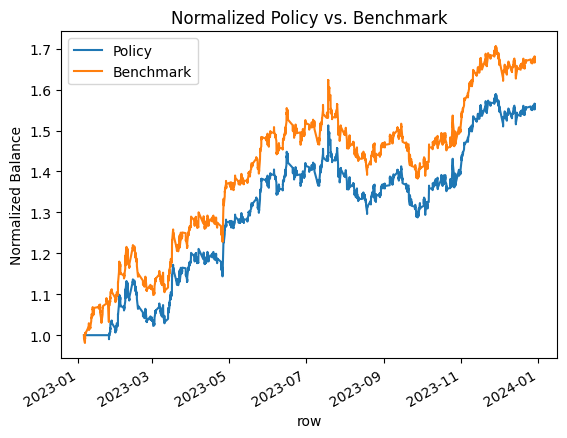

In [11]:
from stable_baselines3.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt

env = StockTradingEnv(df_valid, sample_window=45, max_val=max_val, min_val=min_val, datetime_series=datetime_series_valid, commission_rate=0.001)
check_env(env)
model = PPO.load('ppo_stock', env=env)

obs, info = env.reset()
done = False

log = pd.DataFrame()
while(not done):
    action, _ = model.predict(obs)
    obs, _, done, _, info = env.step(action)
    log = pd.concat([log, pd.DataFrame(info, index=[info['Date']])])

log.to_csv("what.csv")
log['Benchmark'] = env.initial_balance / log['Close'][0] * log['Close']
log['Policy'] = log['Total']

log['Policy'] /= log['Benchmark'][0]
log['Benchmark'] /= log['Benchmark'][0]

ax = log[['Policy', 'Benchmark']].plot(title='Normalized Policy vs. Benchmark')
ax.set_xlabel('row')
ax.set_ylabel('Normalized Balance')
plt.show()  

### Replay Buffer

In [3]:
import numpy as np

class ReplayBuffer:
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.terminal_memory[index] = done
        self.reward_memory[index] = reward
        self.action_memory[index] = action

        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        states_ = self.new_state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, states_, dones

### Actor-Critic Networks

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
import os

class CriticNetwork(keras.Model):
    def __init__(self, fc1_dims, fc2_dims, name, chkpt_dir='tmp/td3'):
        super(CriticNetwork, self).__init__()
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.model_name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_td3')

        self.fc1 = Dense(self.fc1_dims, activation='relu')
        self.fc2 = Dense(self.fc2_dims, activation='relu')
        self.q = Dense(1, activation=None)

    def call(self, state, action):
        q1_action_value = self.fc1(tf.concat([state, action], axis=1))
        q1_action_value = self.fc2(q1_action_value)

        q = self.q(q1_action_value)

        return q


class ActorNetwork(keras.Model):
    def __init__(self, fc1_dims, fc2_dims, n_actions, name,
                 chkpt_dir='tmp/td3'):
        super(ActorNetwork, self).__init__()
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.model_name = name
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_td3')

        self.fc1 = Dense(self.fc1_dims, activation='relu')
        self.fc2 = Dense(self.fc2_dims, activation='relu')
        self.mu = Dense(self.n_actions, activation='tanh')

    def call(self, state):
        prob = self.fc1(state)
        prob = self.fc2(prob)

        mu = self.mu(prob)

        return mu

### Agent

In [ ]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np

class Agent:
    def __init__(self, alpha, beta, input_dims, tau, env,
                 gamma=0.99, update_actor_interval=2, warmup=1000,
                 n_actions=2, max_size=1000000, layer1_size=400,
                 layer2_size=300, batch_size=100, noise=0.1):
        self.gamma = gamma
        self.tau = tau
        self.max_action = env.action_space.high[0]
        self.min_action = env.action_space.low[0]
        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        self.batch_size = batch_size
        self.learn_step_cntr = 0
        self.time_step = 0
        self.warmup = warmup
        self.n_actions = n_actions
        self.update_actor_iter = update_actor_interval

        self.actor = ActorNetwork(layer1_size, layer2_size,
                                  n_actions=n_actions, name='actor')

        self.critic_1 = CriticNetwork(layer1_size, layer2_size,
                                      name='critic_1')
        self.critic_2 = CriticNetwork(layer1_size, layer2_size,
                                      name='critic_2')

        self.target_actor = ActorNetwork(layer1_size, layer2_size,
                                         n_actions=n_actions,
                                         name='target_actor')
        self.target_critic_1 = CriticNetwork(layer1_size, layer2_size,
                                             name='target_critic_1')
        self.target_critic_2 = CriticNetwork(layer1_size, layer2_size,
                                             name='target_critic_2')

        self.actor.compile(optimizer=Adam(learning_rate=alpha), loss='mean')
        self.critic_1.compile(optimizer=Adam(learning_rate=beta),
                              loss='mean_squared_error')
        self.critic_2.compile(optimizer=Adam(learning_rate=beta),
                              loss='mean_squared_error')

        self.target_actor.compile(optimizer=Adam(learning_rate=alpha),
                                  loss='mean')
        self.target_critic_1.compile(optimizer=Adam(learning_rate=beta),
                                     loss='mean_squared_error')
        self.target_critic_2.compile(optimizer=Adam(learning_rate=beta),
                                     loss='mean_squared_error')

        self.noise = noise
        self.update_network_parameters(tau=1)

    def choose_action(self, observation):
        if self.time_step < self.warmup:
            mu = np.random.normal(scale=self.noise, size=(self.n_actions,))
        else:
            state = tf.convert_to_tensor([observation], dtype=tf.float32)
            # returns a batch size of 1, want a scalar array
            mu = self.actor(state)[0]
        mu_prime = mu + np.random.normal(scale=self.noise)

        mu_prime = tf.clip_by_value(mu_prime, self.min_action, self.max_action)
        self.time_step += 1

        return mu_prime

    def remember(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        states, actions, rewards, new_states, dones = \
            self.memory.sample_buffer(self.batch_size)

        states = tf.convert_to_tensor(states, dtype=tf.float32)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
        states_ = tf.convert_to_tensor(new_states, dtype=tf.float32)

        with tf.GradientTape(persistent=True) as tape:
            target_actions = self.target_actor(states_)
            target_actions = target_actions + \
                tf.clip_by_value(np.random.normal(scale=0.2), -0.5, 0.5)

            target_actions = tf.clip_by_value(target_actions, self.min_action,
                                              self.max_action)

            q1_ = self.target_critic_1(states_, target_actions)
            q2_ = self.target_critic_2(states_, target_actions)

            q1 = tf.squeeze(self.critic_1(states, actions), 1)
            q2 = tf.squeeze(self.critic_2(states, actions), 1)

            # shape is [batch_size, 1], want to collapse to [batch_size]
            q1_ = tf.squeeze(q1_, 1)
            q2_ = tf.squeeze(q2_, 1)

            critic_value_ = tf.math.minimum(q1_, q2_)
            # in tf2 only integer scalar arrays can be used as indices
            # and eager exection doesn't support assignment, so we can't do
            # q1_[dones] = 0.0
            target = rewards + self.gamma*critic_value_*(1-dones)
            critic_1_loss = keras.losses.MSE(target, q1)
            critic_2_loss = keras.losses.MSE(target, q2)

        critic_1_gradient = tape.gradient(critic_1_loss,
                                          self.critic_1.trainable_variables)
        critic_2_gradient = tape.gradient(critic_2_loss,
                                          self.critic_2.trainable_variables)

        self.critic_1.optimizer.apply_gradients(
                   zip(critic_1_gradient, self.critic_1.trainable_variables))
        self.critic_2.optimizer.apply_gradients(
                   zip(critic_2_gradient, self.critic_2.trainable_variables))

        self.learn_step_cntr += 1

        if self.learn_step_cntr % self.update_actor_iter != 0:
            return

        with tf.GradientTape() as tape:
            new_actions = self.actor(states)
            critic_1_value = self.critic_1(states, new_actions)
            actor_loss = -tf.math.reduce_mean(critic_1_value)

        actor_gradient = tape.gradient(actor_loss,
                                       self.actor.trainable_variables)
        self.actor.optimizer.apply_gradients(
                        zip(actor_gradient, self.actor.trainable_variables))

        self.update_network_parameters()

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        weights = []
        targets = self.target_actor.weights
        for i, weight in enumerate(self.actor.weights):
            weights.append(weight * tau + targets[i]*(1-tau))

        self.target_actor.set_weights(weights)

        weights = []
        targets = self.target_critic_1.weights
        for i, weight in enumerate(self.critic_1.weights):
            weights.append(weight * tau + targets[i]*(1-tau))

        self.target_critic_1.set_weights(weights)

        weights = []
        targets = self.target_critic_2.weights
        for i, weight in enumerate(self.critic_2.weights):
            weights.append(weight * tau + targets[i]*(1-tau))

        self.target_critic_2.set_weights(weights)

    def save_models(self):
        print('... saving models ...')
        self.actor.save_weights(self.actor.checkpoint_file)
        self.critic_1.save_weights(self.critic_1.checkpoint_file)
        self.critic_2.save_weights(self.critic_2.checkpoint_file)
        self.target_actor.save_weights(self.target_actor.checkpoint_file)
        self.target_critic_1.save_weights(self.target_critic_1.checkpoint_file)
        self.target_critic_2.save_weights(self.target_critic_2.checkpoint_file)

    def load_models(self):
        print('... loading models ...')
        self.actor.load_weights(self.actor.checkpoint_file)
        self.critic_1.load_weights(self.critic_1.checkpoint_file)
        self.critic_2.load_weights(self.critic_2.checkpoint_file)
        self.target_actor.load_weights(self.target_actor.checkpoint_file)
        self.target_critic_1.load_weights(self.target_critic_1.checkpoint_file)
        self.target_critic_2.load_weights(self.target_critic_2.checkpoint_file)

### Run the algorithm

In [ ]:
import gym
import numpy as np
from agent import Agent

if __name__ == '__main__':
    env = gym.make('BipedalWalker-v3')
    agent = Agent(alpha=0.001, beta=0.001,
            input_dims=env.observation_space.shape, tau=0.005,
            env=env, batch_size=100, layer1_size=400, layer2_size=300,
            n_actions=env.action_space.shape[0])
    n_games = 1000

    best_score = env.reward_range[0]
    score_history = []

    #agent.load_models()

    for i in range(n_games):
        observation = env.reset()
        done = False
        score = 0
        while not done:
            action = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            agent.remember(observation, action, reward, observation_, done)
            agent.learn()
            score += reward
            observation = observation_
        score_history.append(score)
        avg_score = np.mean(score_history[-100:])

        if avg_score > best_score:
            best_score = avg_score
            agent.save_models()

        print('episode ', i, 'score %.1f' % score,
                'average score %.1f' % avg_score)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

class PPO:
    def __init__(self, state_dim, action_dim, hidden_dim, lr, gamma, clip_epsilon, epochs, batch_size):
        self.actor = Actor(state_dim, action_dim, hidden_dim)
        self.critic = Critic(state_dim, hidden_dim)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr)
        self.gamma = gamma
        self.clip_epsilon = clip_epsilon
        self.epochs = epochs
        self.batch_size = batch_size

    def update(self, states, actions, rewards, next_states, dones):
        states = torch.tensor(states, dtype=torch.float)
        actions = torch.tensor(actions, dtype=torch.float)
        rewards = torch.tensor(rewards, dtype=torch.float)
        next_states = torch.tensor(next_states, dtype=torch.float)
        dones = torch.tensor(dones, dtype=torch.float)

        for _ in range(self.epochs):
            indices = np.arange(states.shape[0])
            np.random.shuffle(indices)

            for start in range(0, states.shape[0], self.batch_size):
                end = start + self.batch_size
                batch_indices = indices[start:end]

                batch_states = states[batch_indices]
                batch_actions = actions[batch_indices]
                batch_rewards = rewards[batch_indices]
                batch_next_states = next_states[batch_indices]
                batch_dones = dones[batch_indices]

                # Update critic
                values = self.critic(batch_states)
                next_values = self.critic(batch_next_states)
                targets = batch_rewards + self.gamma * next_values * (1 - batch_dones)
                critic_loss = nn.MSELoss()(values, targets.detach())
                self.critic_optimizer.zero_grad()
                critic_loss.backward()
                self.critic_optimizer.step()

                # Update actor
                old_probs = self.actor(batch_states).gather(1, batch_actions.long().unsqueeze(1)).squeeze()
                new_probs = self.actor(batch_states).gather(1, batch_actions.long().unsqueeze(1)).squeeze()
                ratio = new_probs / (old_probs + 1e-8)
                advantages = targets - values.detach()
                surr1 = ratio * advantages
                surr2 = torch.clamp(ratio, 1 - self.clip_epsilon, 1 + self.clip_epsilon) * advantages
                actor_loss = -torch.min(surr1, surr2).mean()
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()

    def act(self, state):
        state = torch.tensor(state, dtype=torch.float).unsqueeze(0)
        probs = self.actor(state)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        return action.item()

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.softmax(self.fc3(x), dim=-1)
        return x

class Critic(nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
import gym

# Create an instance of the environment
env = gym.make('CartPole-v1')

# Define the hyperparameters
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
hidden_dim = 64
lr = 0.001
gamma = 0.99
clip_epsilon = 0.2
epochs = 10
batch_size = 64
num_episodes = 1000

# Create an instance of the PPO agent
agent = PPO(state_dim, action_dim, hidden_dim, lr, gamma, clip_epsilon, epochs, batch_size)

# Training loop
for episode in range(num_episodes):
    state = env.reset()
    done = False
    episode_reward = 0

    while not done:
        action = agent.act(state)
        next_stat

ModuleNotFoundError: No module named 'gym'

In [1]:
!pip install gym
import gym